In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.lstm import LSTMModel
from src.training_utils import *

### Load segmented data

In [2]:
# define data directory
data_dir = '../data/'

In [3]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

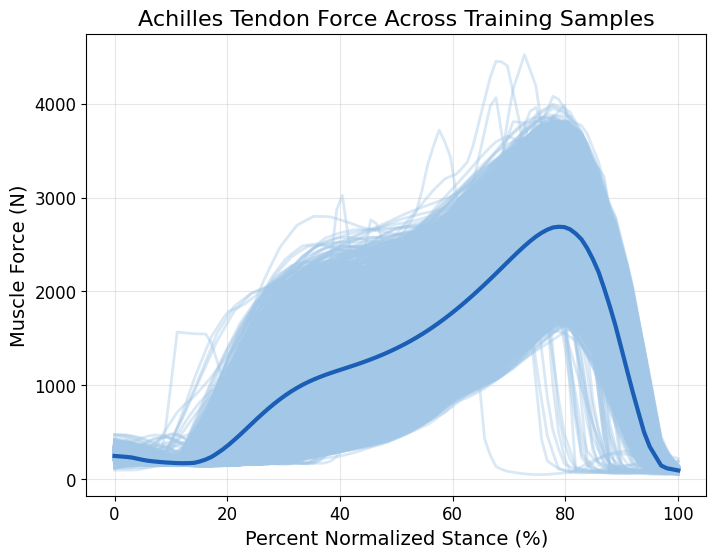

In [4]:
# plot data to double check
plot_achilles_force(y_train)

### Initialize model

In [5]:
# model parameters
input_size = 3  # grf features (x, y, z)
hidden_size = 64  # hidden size for LSTM (tunable)
num_layers = 2  # number of LSTM layers
output_size = 9  # muscle force features

# create the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [6]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [7]:
# move the model to the device
model.to(device)

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

### Initialize hyperparameters and data loaders

In [8]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### Train model

In [9]:
best_model, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 264242.8116, Val Loss: 260313.2479
Epoch [10/1000], Train Loss: 209618.8478, Val Loss: 207553.0257
Epoch [20/1000], Train Loss: 165290.4053, Val Loss: 163671.1330
Epoch [30/1000], Train Loss: 128382.7817, Val Loss: 127209.2660
Epoch [40/1000], Train Loss: 98010.4355, Val Loss: 97071.6903
Epoch [50/1000], Train Loss: 73379.6468, Val Loss: 72823.7451
Epoch [60/1000], Train Loss: 53798.7018, Val Loss: 53343.5368
Epoch [70/1000], Train Loss: 38552.7669, Val Loss: 38454.7271
Epoch [80/1000], Train Loss: 27032.7595, Val Loss: 26864.0381
Epoch [90/1000], Train Loss: 18626.1483, Val Loss: 18683.1790
Epoch [100/1000], Train Loss: 12550.9266, Val Loss: 12643.3622
Epoch [110/1000], Train Loss: 8381.0075, Val Loss: 8664.7236
Epoch [120/1000], Train Loss: 5677.5659, Val Loss: 6297.1166
Epoch [130/1000], Train Loss: 4427.4039, Val Loss: 4516.8435
Epoch [140/1000], Train Loss: 3230.9785, Val Loss: 3554.5927
Epoch [150/1000], Train Loss: 2687.9383, Val Loss: 3132.0082
Epoch

### Test model

In [10]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 2339.7988


### Plot sample prediction

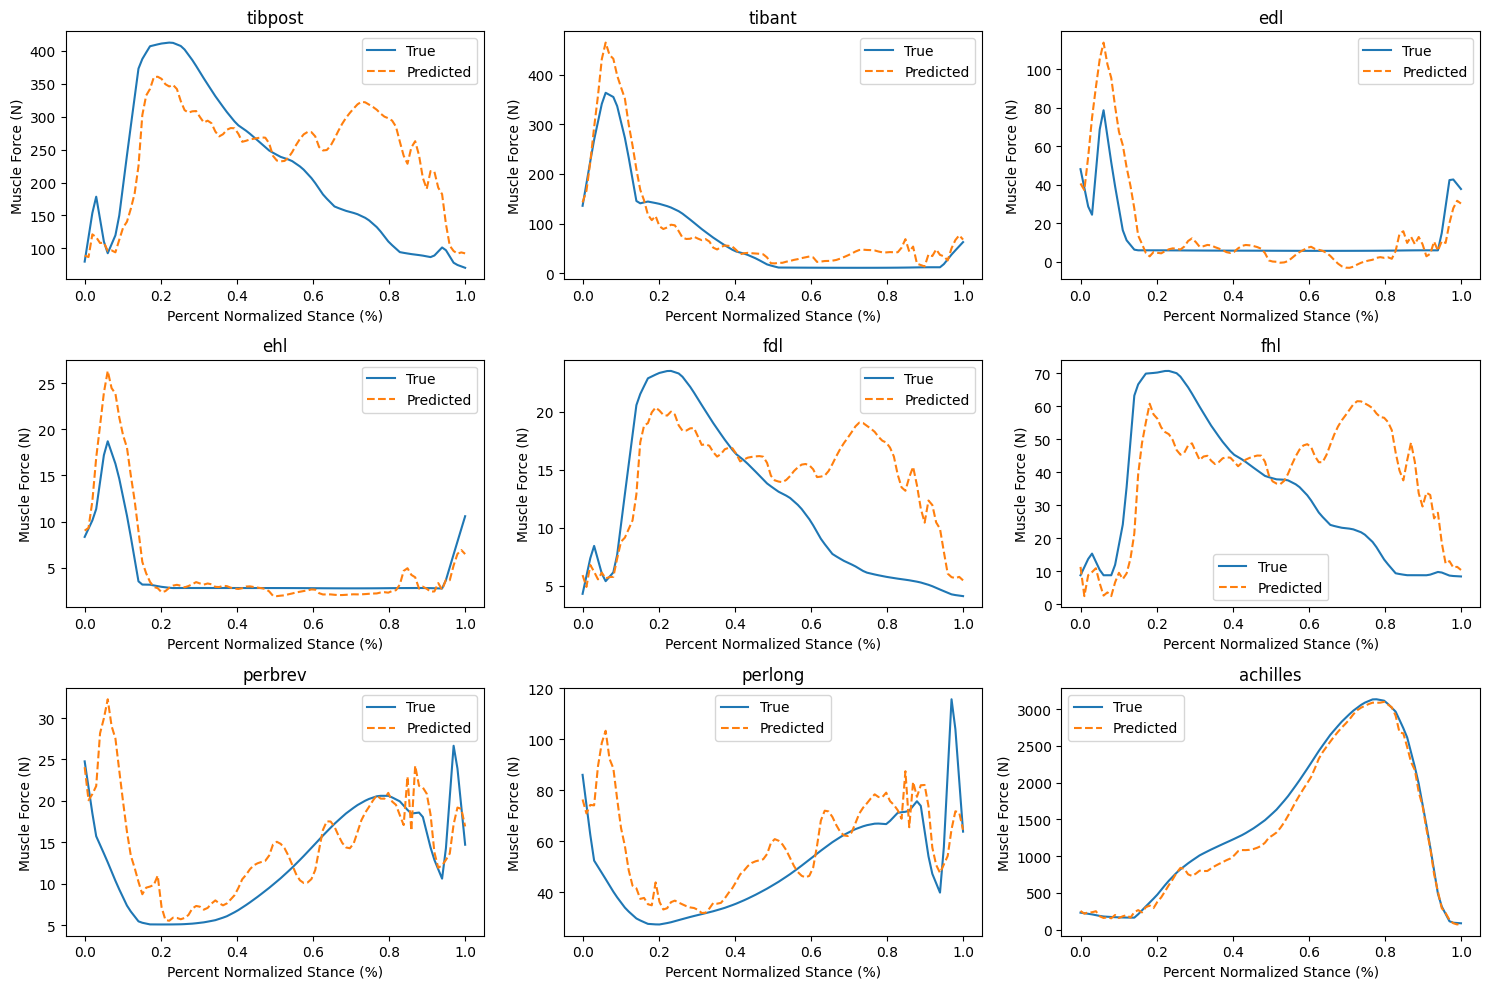

In [11]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)